In [1]:
import os
import torch
import splitfolders
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

%matplotlib inline

from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
input_dir = "Lab1\simpsons_dataset"
PATH = "Lab1\data"

#splitfolders.ratio(input_dir, output=PATH,seed=1332, ratio=(.7, 0.2,0.1))

image_size = (64, 64, 3)
epochs = 10
classes = os.listdir(input_dir)
print(classes)

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [26]:
def image_shower(images, labels, n):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image / 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%6s' % classes[label] for label in labels[:n]))
    
transform = transforms.Compose(
    [transforms.Resize((64,64)), 
     transforms.ToTensor()])
#использовать для демонстрации работы

Real Labels:  marge_simpson lisa_simpson kent_brockman marge_simpson sideshow_bob lisa_simpson


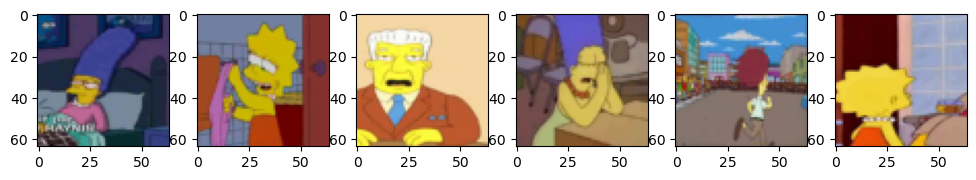

In [28]:
images, labels = next(iter(trainloader))
image_shower(images, labels,6)

In [4]:
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"),
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=100,
                                          num_workers=0,
                                          shuffle=True)


valset = torchvision.datasets.ImageFolder(os.path.join(PATH, "val"),
                                           transform=transform)
valloader = torch.utils.data.DataLoader(valset,
                                         batch_size=80,
                                         num_workers=0,
                                         shuffle=True)


testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"),
                                           transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=100,
                                         num_workers=0,
                                         shuffle=True)


In [5]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.require = False

model.fc = nn.Linear(512, 42)

criterion = nn.CrossEntropyLoss() ######
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

print(torchinfo.summary(model, input_size=(100, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 42]                 --
├─Conv2d: 1-1                            [100, 64, 32, 32]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 32, 32]         128
├─ReLU: 1-3                              [100, 64, 32, 32]         --
├─MaxPool2d: 1-4                         [100, 64, 16, 16]         --
├─Sequential: 1-5                        [100, 64, 16, 16]         --
│    └─BasicBlock: 2-1                   [100, 64, 16, 16]         --
│    │    └─Conv2d: 3-1                  [100, 64, 16, 16]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 16, 16]         128
│    │    └─ReLU: 3-3                    [100, 64, 16, 16]         --
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 16, 16]         128
│    │    └─ReLU: 3-6                    [100, 64, 16, 16]         --
│

In [6]:
train_losses = []
val_losses= []

for epoch in range(epochs):
    train_loss, val_loss, correct_train, correct_val = 0, 0, 0, 0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prediction = outputs.max(dim=1, keepdim=True)[1]
        correct_train += prediction.eq(labels.view_as(prediction)).sum()
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(valloader, 0)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            prediction = outputs.max(dim=1, keepdim=True)[1]
            correct_val += prediction.eq(labels.view_as(prediction)).sum()

    train_loss/=len(trainloader)
    val_loss/=len(valloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    
    print ("Epoch {} - Train loss: {} ".format(epoch+1, train_loss))
    print ("Epoch {} - Val loss: {} ".format(epoch+1, val_loss))

208it [03:52,  1.12s/it]
98it [00:48,  2.02it/s]


Epoch 1 - Train loss: 2.230527312709735 
Epoch 1 - Val loss: 1.2511291327525158 


208it [04:12,  1.21s/it]
98it [00:47,  2.07it/s]


Epoch 2 - Train loss: 1.017731544203483 
Epoch 2 - Val loss: 0.7083703756940608 


208it [04:00,  1.16s/it]
98it [00:46,  2.10it/s]


Epoch 3 - Train loss: 0.6152752372794427 
Epoch 3 - Val loss: 0.4506456608674964 


208it [04:06,  1.18s/it]
98it [00:51,  1.91it/s]


Epoch 4 - Train loss: 0.39511091942684007 
Epoch 4 - Val loss: 0.2946787076641102 


208it [04:11,  1.21s/it]
98it [00:48,  2.03it/s]


Epoch 5 - Train loss: 0.2548420770237079 
Epoch 5 - Val loss: 0.2034775397303153 


208it [04:17,  1.24s/it]
98it [00:49,  1.97it/s]


Epoch 6 - Train loss: 0.1650700388619533 
Epoch 6 - Val loss: 0.1433116594443516 


208it [04:10,  1.20s/it]
98it [00:50,  1.96it/s]


Epoch 7 - Train loss: 0.10975202258962852 
Epoch 7 - Val loss: 0.1067788413516721 


208it [04:15,  1.23s/it]
98it [00:50,  1.93it/s]


Epoch 8 - Train loss: 0.07730994024313986 
Epoch 8 - Val loss: 0.0825867820341064 


208it [04:48,  1.39s/it]
98it [00:53,  1.84it/s]


Epoch 9 - Train loss: 0.05599862101595276 
Epoch 9 - Val loss: 0.06653649703960637 


208it [04:40,  1.35s/it]
98it [00:51,  1.92it/s]

Epoch 10 - Train loss: 0.04138059540239807 
Epoch 10 - Val loss: 0.054793019826542964 


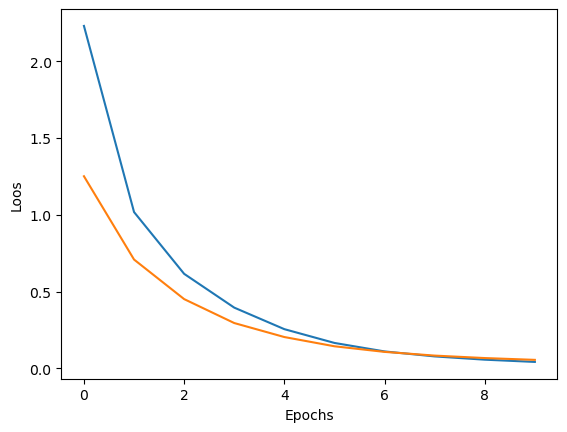

In [9]:
plt.plot([i for i in range(0, epochs)], train_losses)
plt.plot([i for i in range(0, epochs)], val_losses)
plt.ylabel('Loos')
plt.xlabel('Epochs')
plt.show()
#синяя train, оранжевая val

In [10]:
class_correct = list(0. for i in range(42))
class_total = list(0. for i in range(42))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                class_correct[label] += 1
            class_total[label] += 1


for i in range(42):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of abraham_grampa_simpson : 99 %
Accuracy of agnes_skinner : 80 %
Accuracy of apu_nahasapeemapetilon : 99 %
Accuracy of barney_gumble : 83 %
Accuracy of bart_simpson : 100 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 98 %
Accuracy of chief_wiggum : 98 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 96 %
Accuracy of disco_stu : 50 %
Accuracy of edna_krabappel : 98 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 100 %
Accuracy of homer_simpson : 98 %
Accuracy of kent_brockman : 100 %
Accuracy of krusty_the_clown : 99 %
Accuracy of lenny_leonard : 97 %
Accuracy of lionel_hutz :  0 %
Accuracy of lisa_simpson : 99 %
Accuracy of maggie_simpson : 85 %
Accuracy of marge_simpson : 98 %
Accuracy of martin_prince : 87 %
Accuracy of mayor_quimby : 98 %
Accuracy of milhouse_van_houten : 98 %
Accuracy of miss_hoover : 100 %
Accuracy of moe_szyslak : 98 %
Accuracy of ned_flanders : 98 %
Accuracy of ne

Real Labels:  krusty_the_clown marge_simpson mayor_quimby lenny_leonard barney_gumble
Predicted:  krusty_the_clown marge_simpson mayor_quimby lenny_leonard barney_gumble


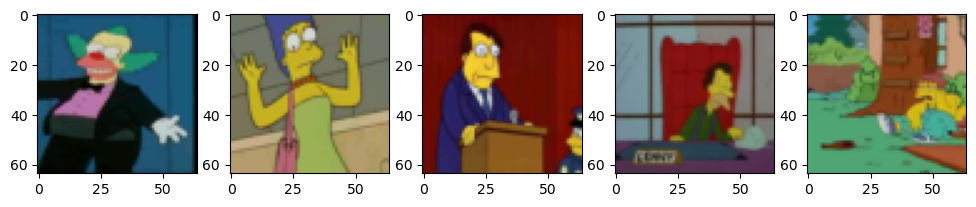

In [31]:
images, labels = next(iter(testloader))
image_shower(images, labels,5)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:5]))